- расстояние Махаланобиса
- хи квадрат
- LedoitWolf
- гауссово распределение
- MLE
- Визуализации

In [1]:
SEED = 42
THRESHOLD = 0.99

MAX_VIS_SAMPLES = 2000

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import chi2

sns.set(style="whitegrid")

In [3]:
def subsample(X_h, X_ai, max_samples):
    n = min(len(X_h), len(X_ai), max_samples // 2)
    X = np.vstack([X_h[:n], X_ai[:n]])
    y = np.concatenate([np.zeros(n), np.ones(n)])
    
    return X, y


def plot_mahalanobis_distributions(scores_human, scores_ai, chi2_threshold, name):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(scores_human, label="Human", fill=True)
    sns.kdeplot(scores_ai, label="AI", fill=True)
    plt.axvline(
        chi2_threshold,
        color="red",
        linestyle="--",
        label=f"threshold ({THRESHOLD})"
    )
    plt.title(f"Распределение значений расстояния Махаланобиса (dataset '{name}')")
    plt.xlabel("Расстояние")
    plt.ylabel("Плотность")
    plt.legend()
    plt.tight_layout()
    
    plt.show()


def plot_roc_curve(y_true, scores, roc_auc, name):
    fpr, tpr, _ = roc_curve(y_true, scores)
    
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve (dataset '{name}')")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    plt.show()


def plot_pca_projection(X_human, X_ai, name):
    X, y = subsample(X_human, X_ai, MAX_VIS_SAMPLES)
    X_2d = PCA(n_components=2, random_state=SEED).fit_transform(X)

    plt.figure(figsize=(8, 5))
    scatter = sns.scatterplot(
        x=X_2d[:, 0], y=X_2d[:, 1],
        hue=y, palette={0: "blue", 1: "orange"},
        alpha=0.5, s=35
    )
    plt.title(f"Проекция PCA (dataset '{name}')")

    handles, _ = scatter.get_legend_handles_labels()
    plt.legend(handles=handles, labels=["Human", "AI"])
    plt.tight_layout()
    
    plt.show()

In [4]:
human_df = (
    pd.read_csv("../datasets/human_essays.csv", encoding="utf-8")
    .assign(label=0)[["text", "label"]]
    .reset_index(drop=True)
)

print(f"Живых текстов: {len(human_df)}")

Живых текстов: 127865


In [5]:
filenames = {
    "Mistral 7B 1": "../datasets/mistral_essays_1.csv",
    "Mistral 7B 2": "../datasets/mistral_essays_2.csv",
    "Mistral 7B 3": "../datasets/mistral_essays_3.csv",
    "Mistral 7B 4": "../datasets/mistral_essays_4.csv",
    "Mistral 7B 5": "../datasets/mistral_essays_5.csv",
    "Llama 3 13B 1": "../datasets/llama_essays_1.csv",
    "Llama 3 13B 2": "../datasets/llama_essays_2.csv",
    "Llama 3 13B 3": "../datasets/llama_essays_3.csv",
    "Llama 3 13B 4": "../datasets/llama_essays_4.csv",
    "Llama 3 13B 5": "../datasets/llama_essays_5.csv",
    "DeepSeek V3.2 1": "../datasets/deepseek_essays_1.csv",
    "DeepSeek V3.2 2": "../datasets/deepseek_essays_2.csv",
    "DeepSeek V3.2 3": "../datasets/deepseek_essays_3.csv",
    "DeepSeek V3.2 4": "../datasets/deepseek_essays_4.csv",
    "DeepSeek V3.2 5": "../datasets/deepseek_essays_5.csv",
    "ChatGPT 1": "../datasets/chatgpt_essays_1.csv",
    "ChatGPT 2": "../datasets/chatgpt_essays_2.csv",
    "ChatGPT 3": "../datasets/chatgpt_essays_3.csv",
    "ChatGPT 4": "../datasets/chatgpt_essays_4.csv",
    "ChatGPT 5": "../datasets/chatgpt_essays_5.csv",
}

ai_datasets = {}
for name, fn in filenames.items():
    df = pd.read_csv(fn, encoding="utf-8").assign(label=1)[["text", "label"]].reset_index(drop=True)
    ai_datasets[name] = df

In [6]:
encoder = SentenceTransformer("all-MiniLM-L6-v2")

X_human = encoder.encode(
    human_df["text"].tolist(),
    batch_size=64,
    normalize_embeddings=False,
    show_progress_bar=True
)

X_h_train, X_h_test = train_test_split(
    X_human,
    test_size=0.2,
    random_state=SEED
)

Batches:   0%|          | 0/1998 [00:00<?, ?it/s]

In [7]:
cov = LedoitWolf().fit(X_h_train)

dim = X_human.shape[1]
chi2_threshold = chi2.ppf(THRESHOLD, df=dim)

print(f"Chi2 threshold (q={THRESHOLD}): {chi2_threshold:.2f}")

scores_h_train = cov.mahalanobis(X_h_train)
emp_threshold = np.quantile(scores_h_train, THRESHOLD)

print(f"Empirical Mahalanobis threshold (q={THRESHOLD}): {emp_threshold:.2f}")

Chi2 threshold (q=0.99): 451.39
Empirical Mahalanobis threshold (q=0.99): 655.69



 DATASET 'Mistral 7B 1' ====================================================


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

ROC-AUC: 0.5835
F1:      0.0324


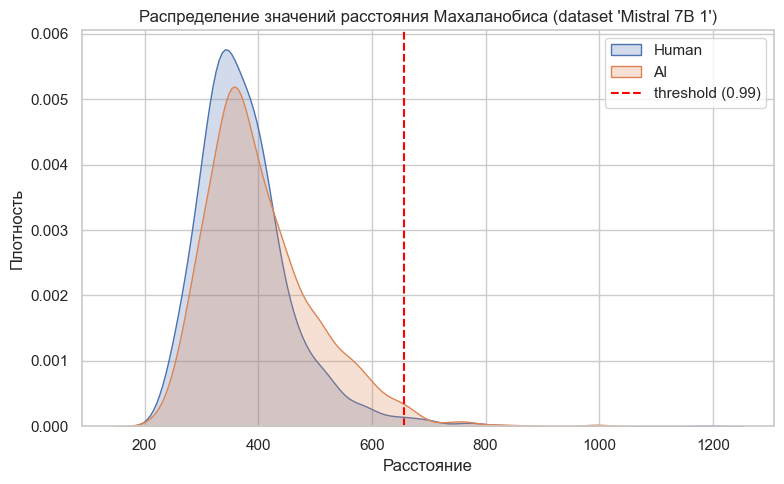

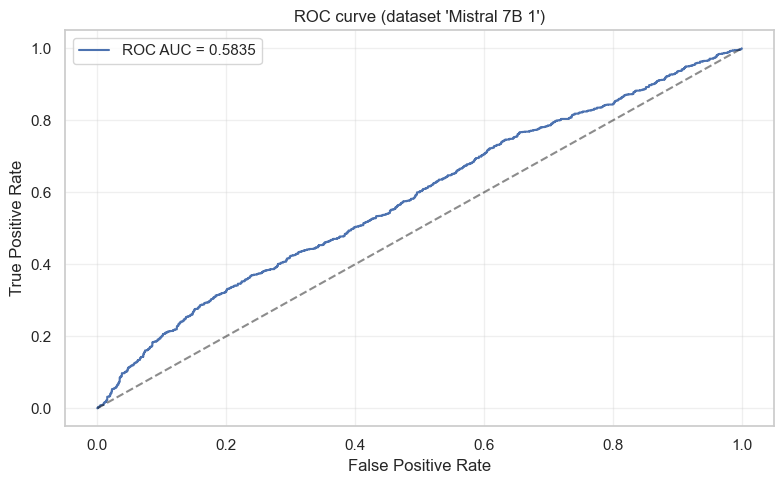

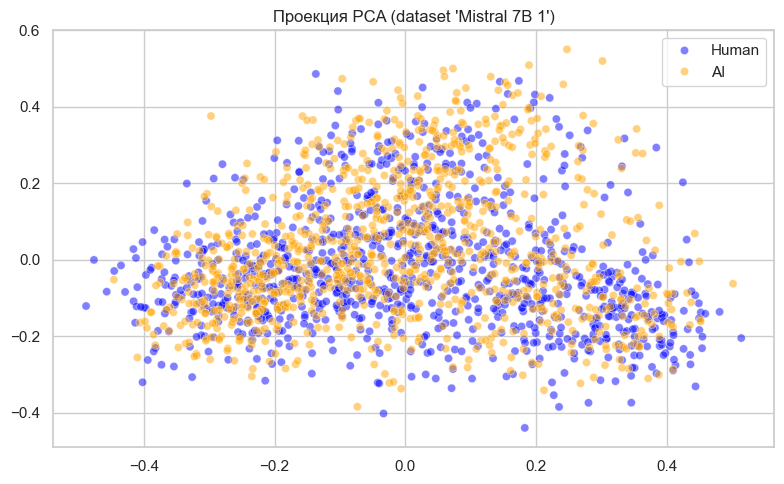


 DATASET 'Mistral 7B 2' ====================================================


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

ROC-AUC: 0.5827
F1:      0.0375


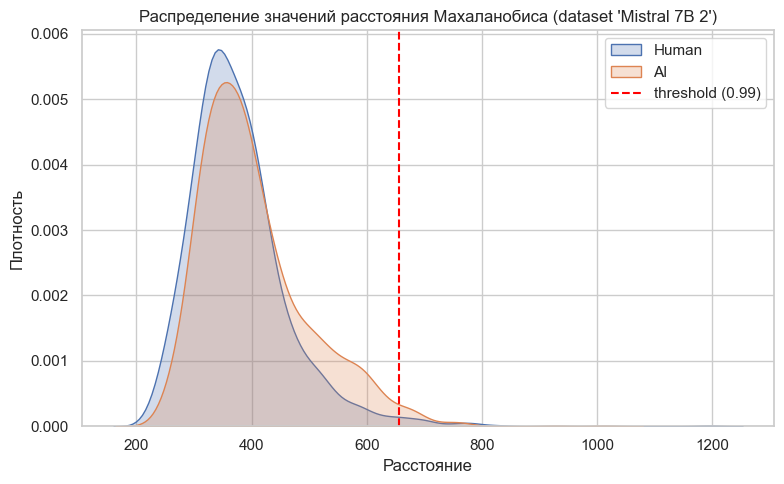

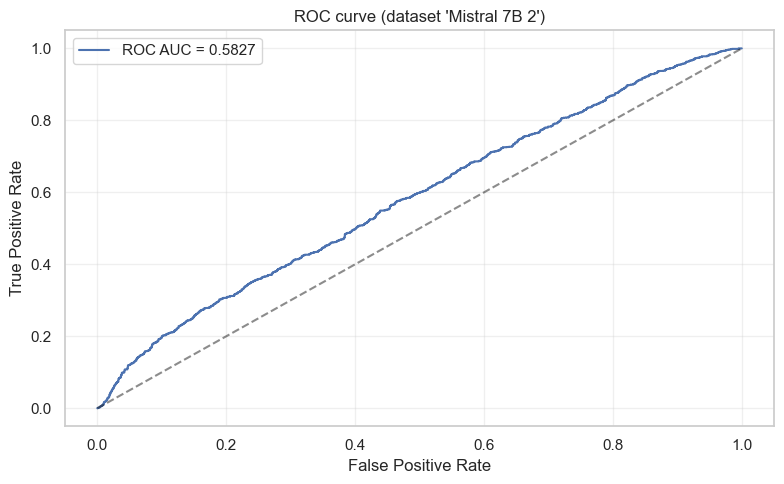

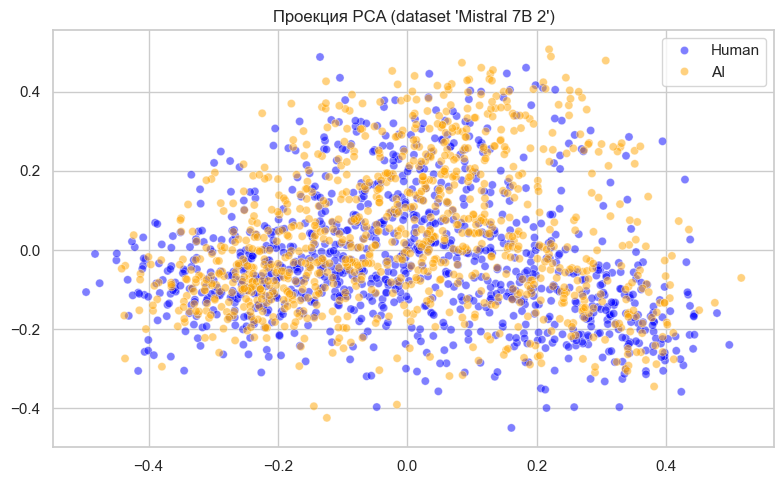


 DATASET 'Mistral 7B 3' ====================================================


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

ROC-AUC: 0.5776
F1:      0.0413


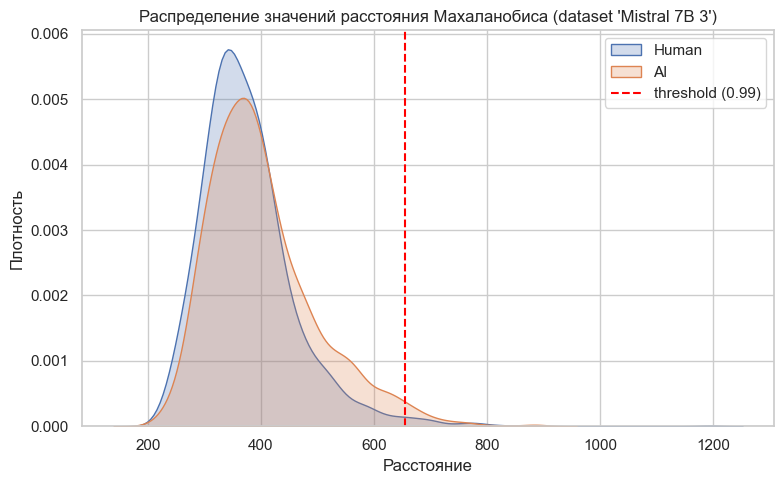

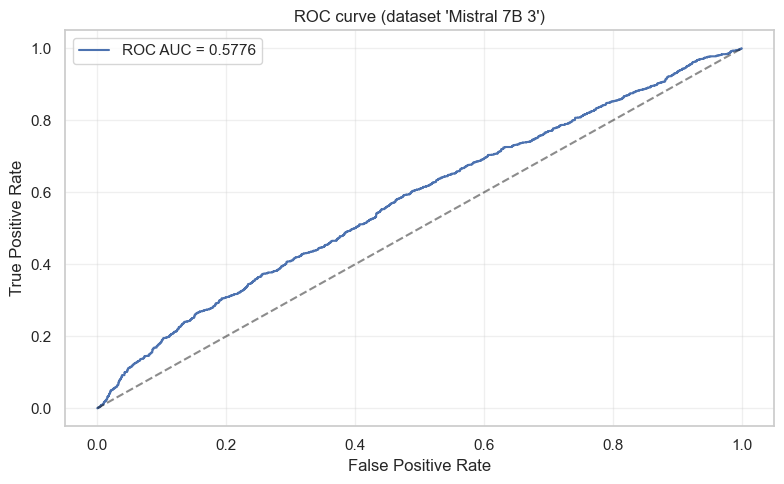

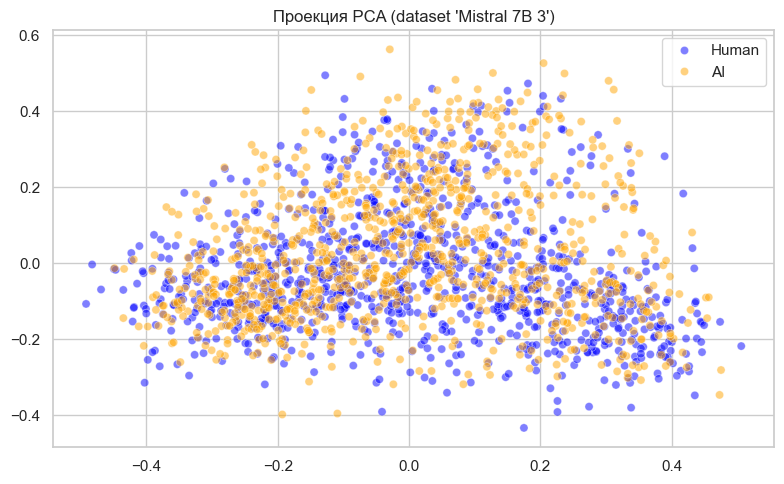


 DATASET 'Mistral 7B 4' ====================================================


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

ROC-AUC: 0.5793
F1:      0.0349


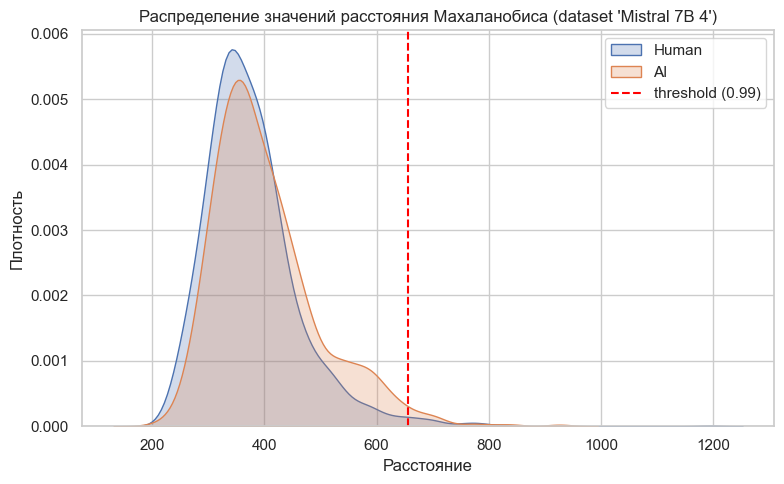

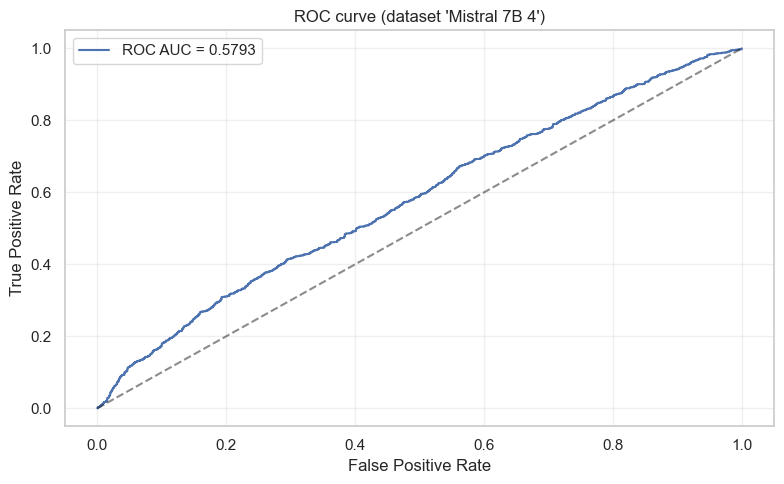

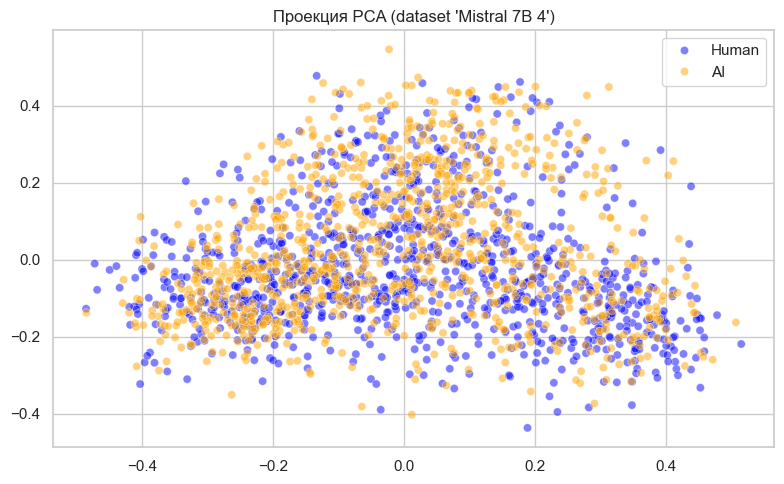


 DATASET 'Mistral 7B 5' ====================================================


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

ROC-AUC: 0.5799
F1:      0.0400


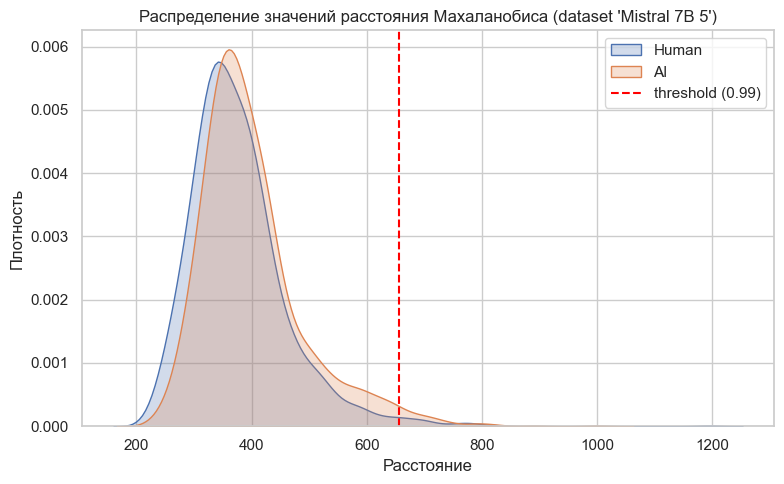

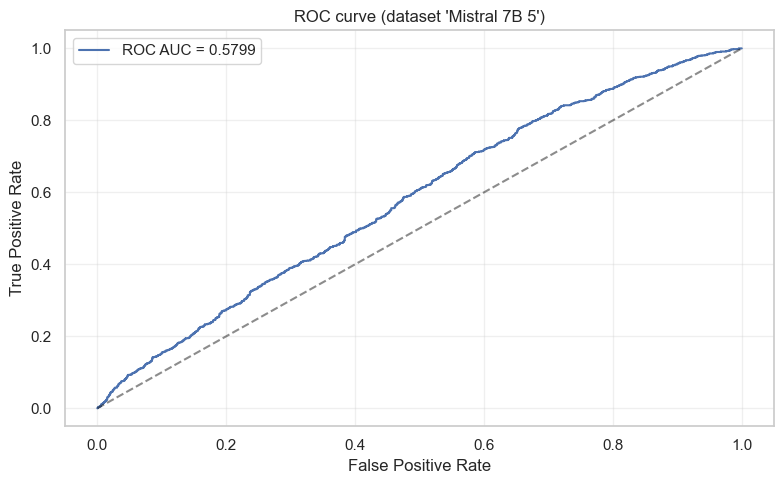

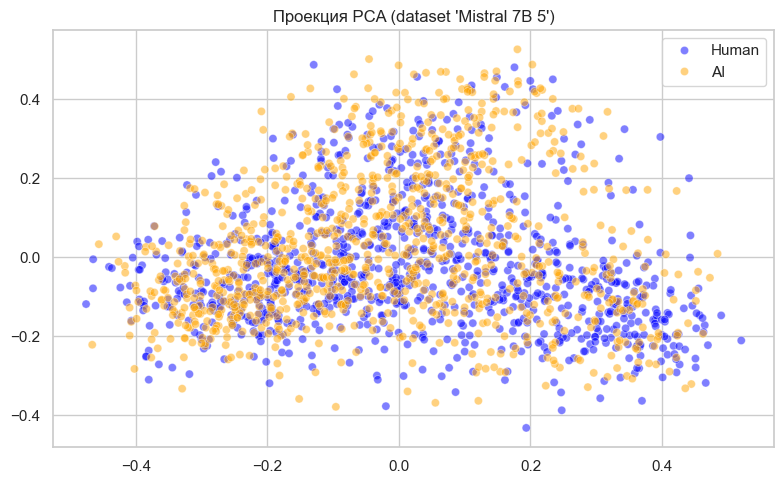


 DATASET 'Llama 3 13B 1' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5831
F1:      0.0369


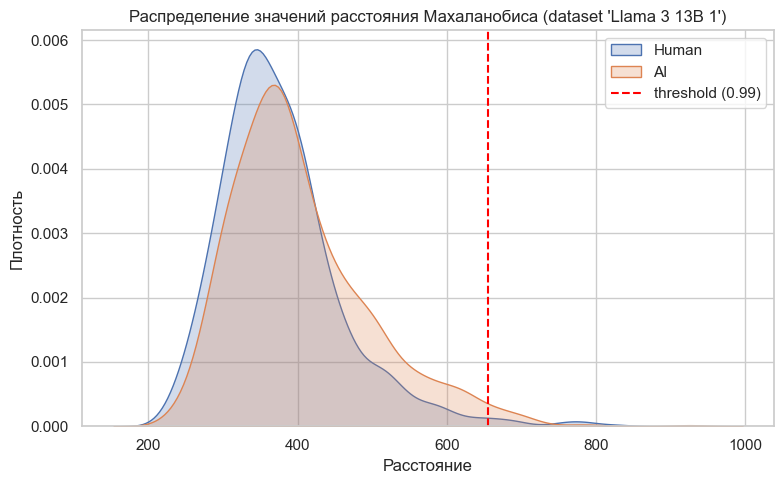

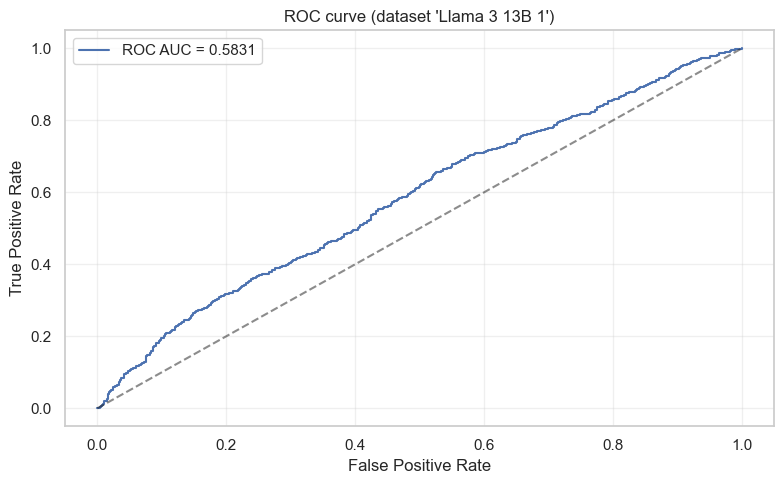

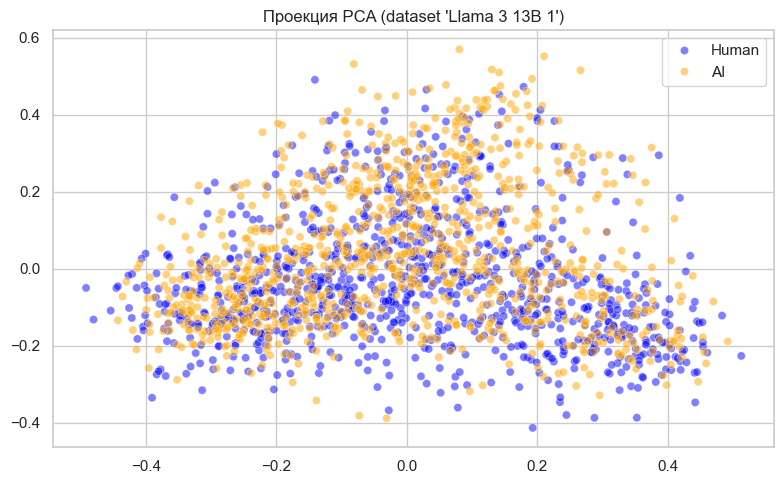


 DATASET 'Llama 3 13B 2' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5833
F1:      0.0426


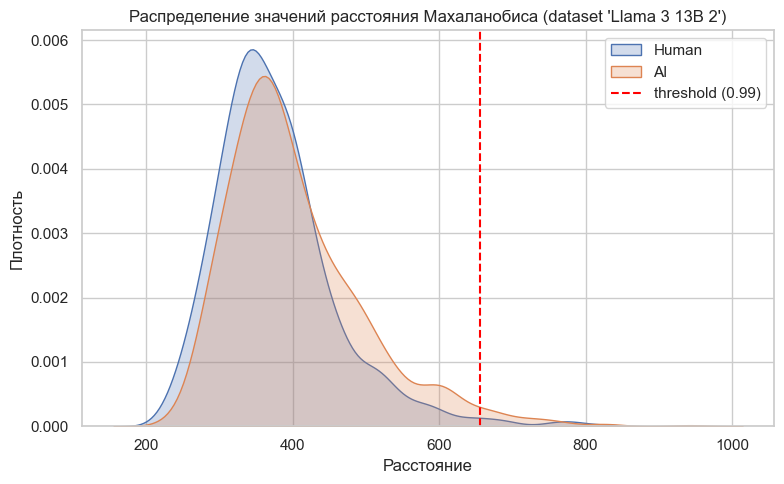

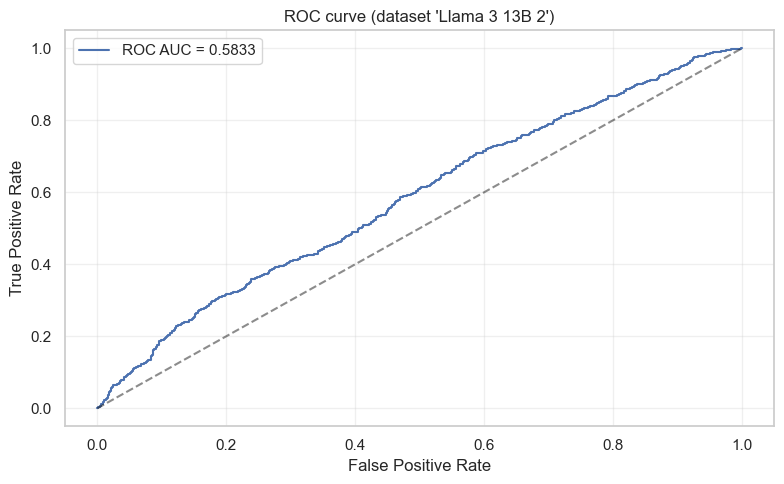

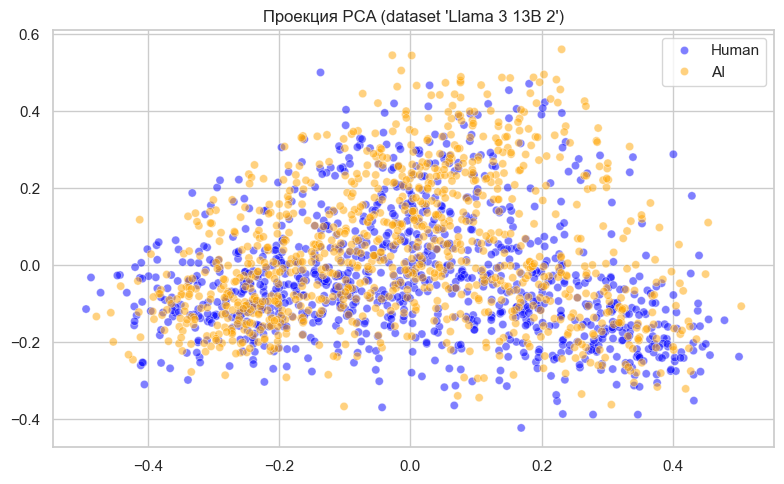


 DATASET 'Llama 3 13B 3' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5762
F1:      0.0483


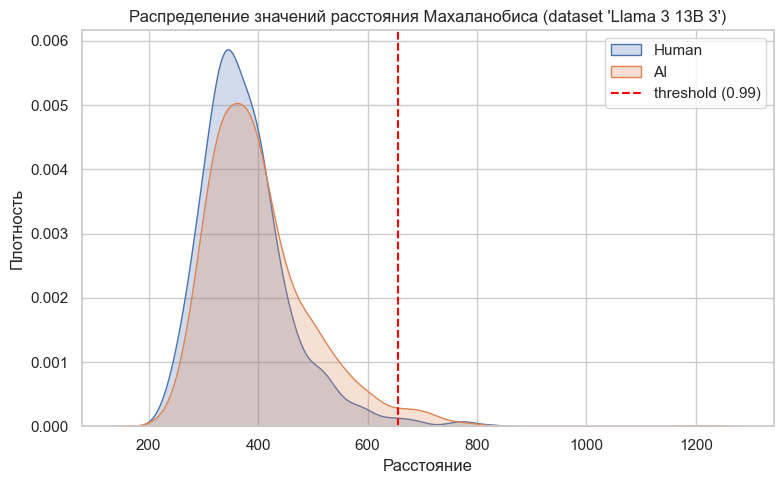

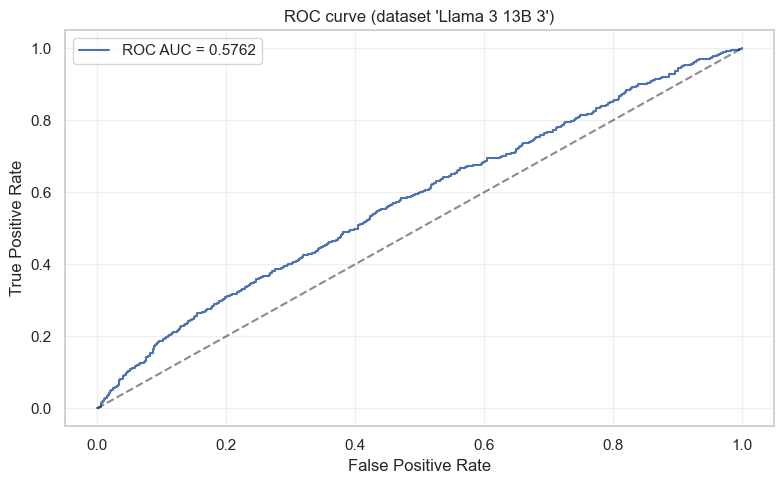

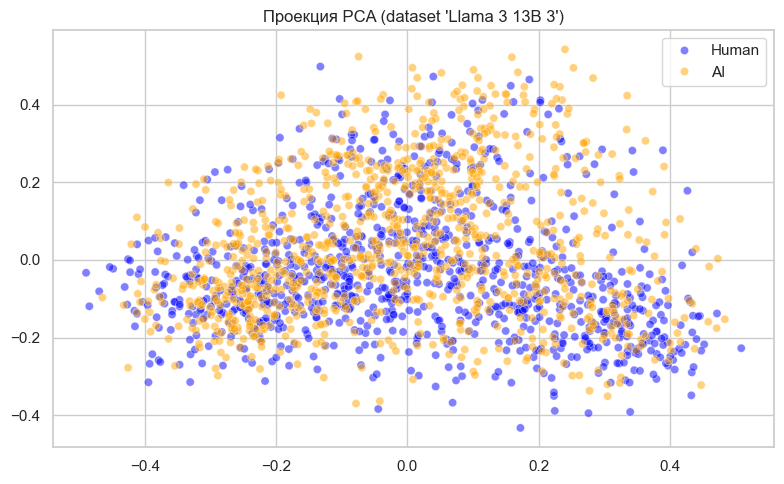


 DATASET 'Llama 3 13B 4' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5699
F1:      0.0445


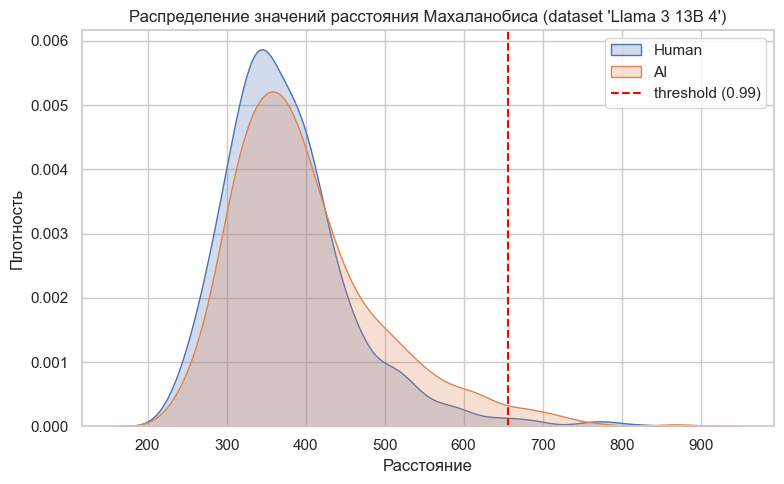

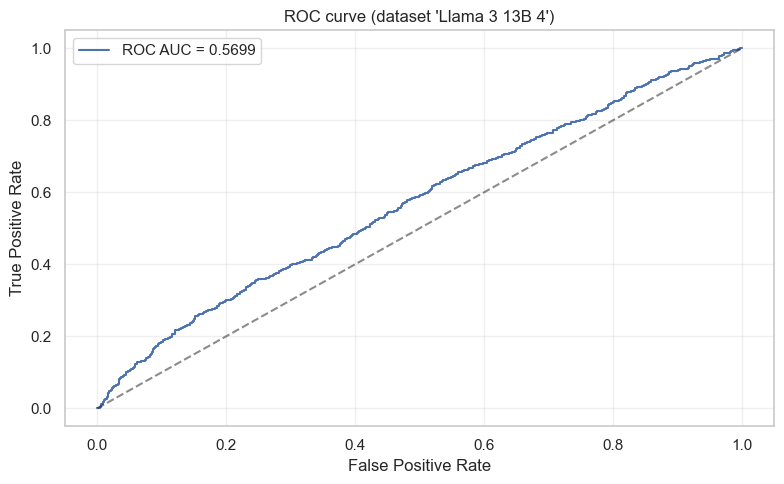

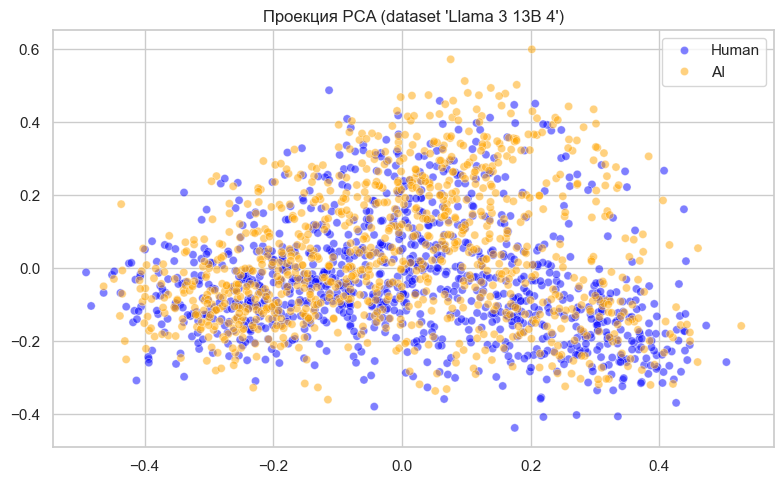


 DATASET 'Llama 3 13B 5' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5513
F1:      0.0369


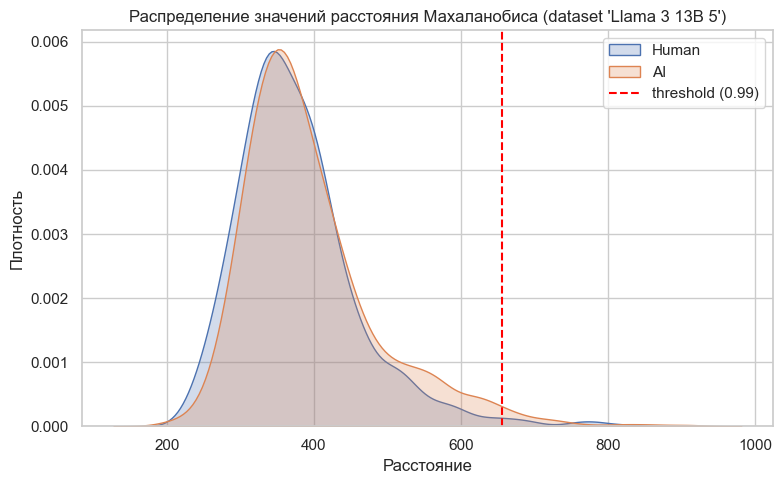

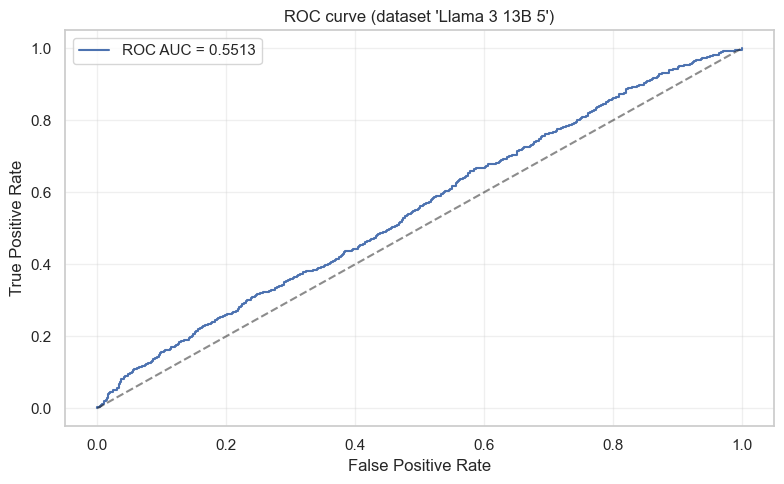

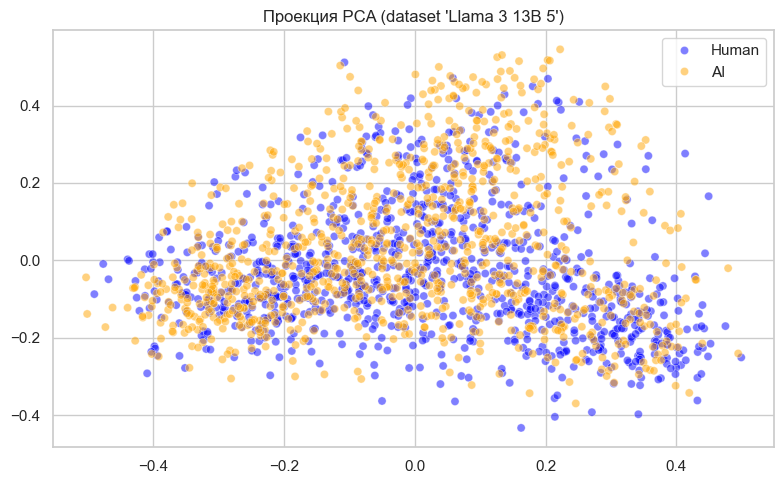


 DATASET 'DeepSeek V3.2 1' ====================================================


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ROC-AUC: 0.4657
F1:      0.0349


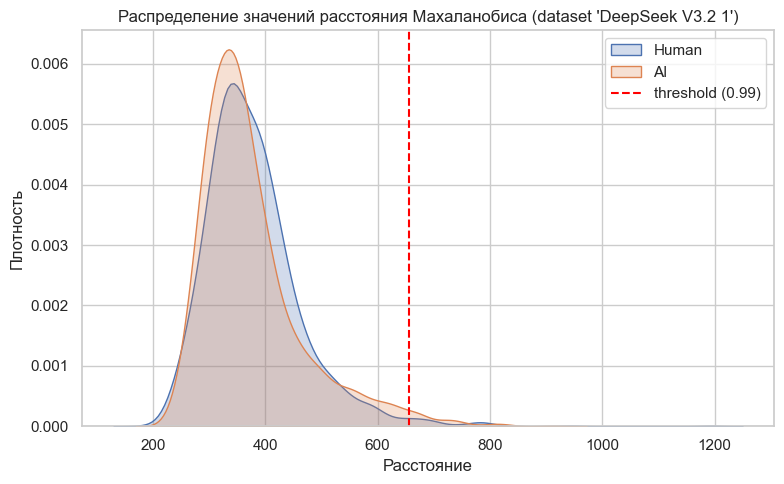

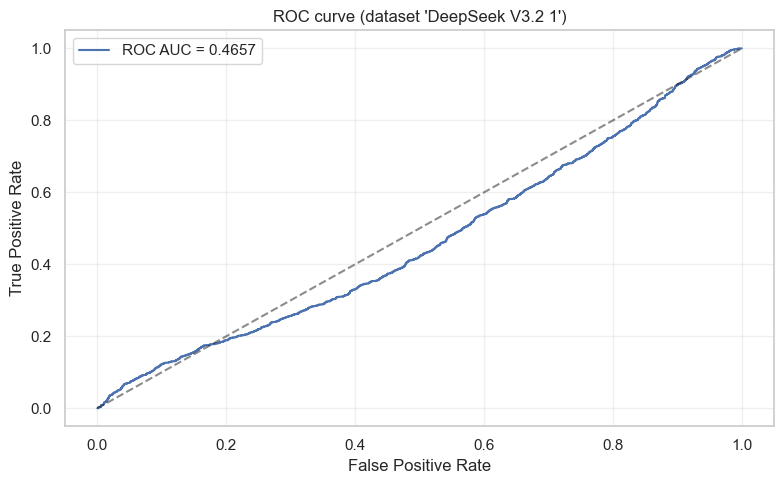

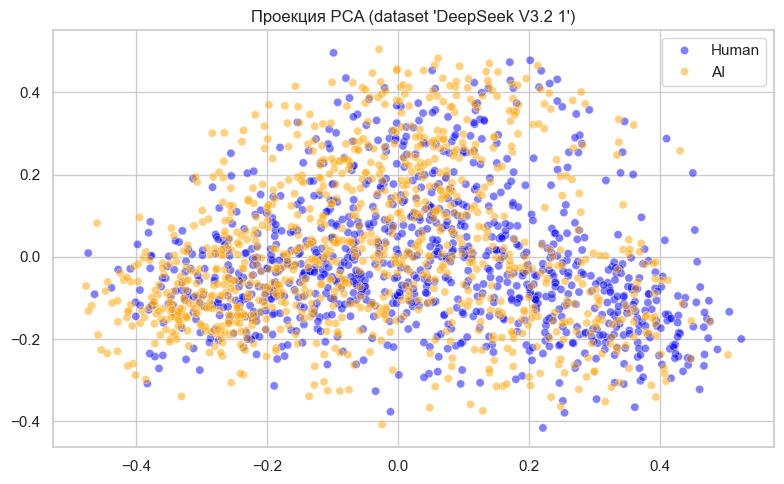


 DATASET 'DeepSeek V3.2 2' ====================================================


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ROC-AUC: 0.4905
F1:      0.0435


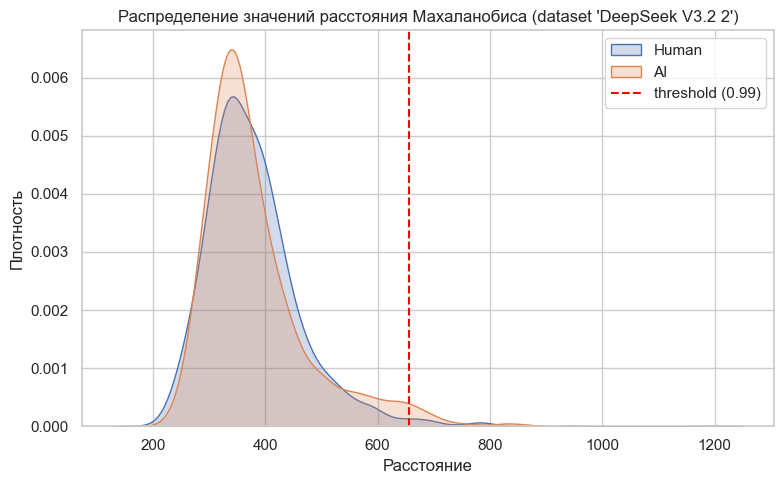

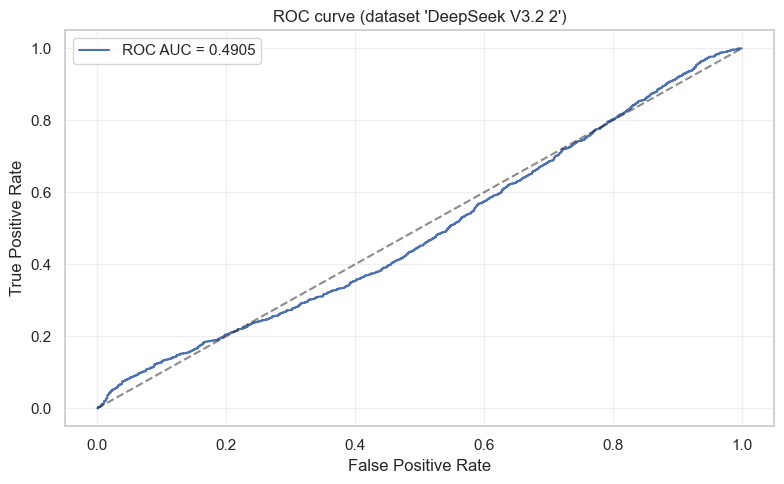

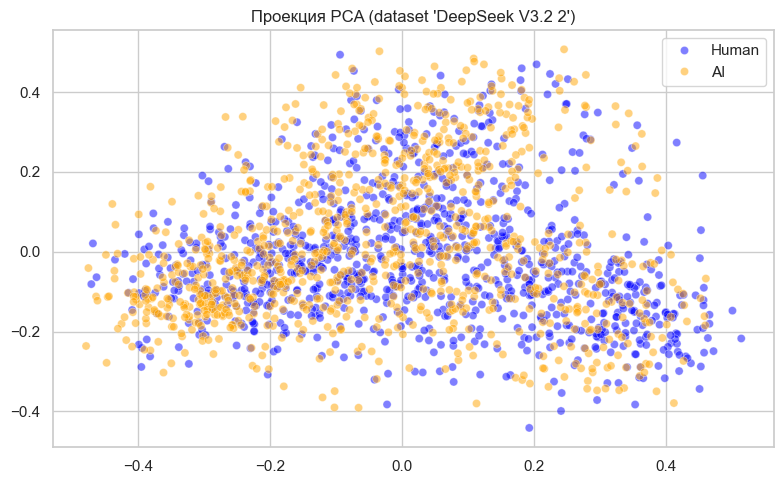


 DATASET 'DeepSeek V3.2 3' ====================================================


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ROC-AUC: 0.4708
F1:      0.0340


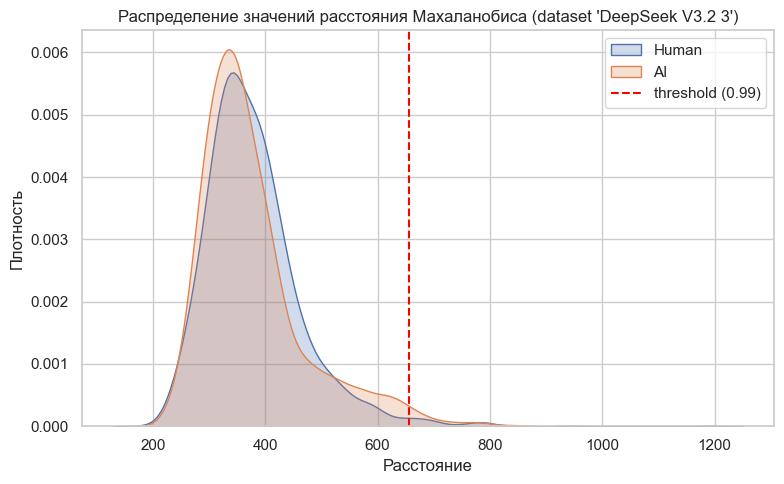

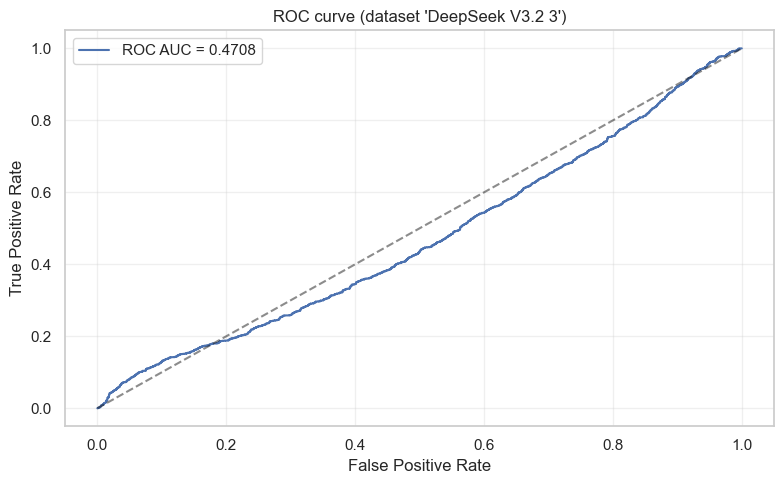

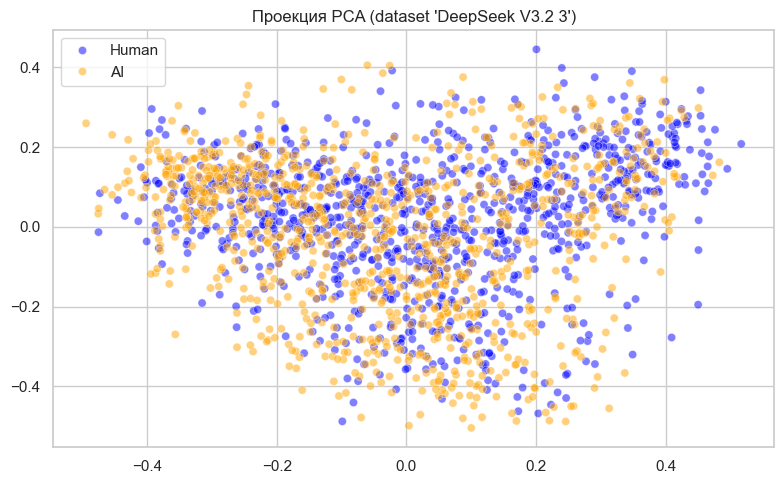


 DATASET 'DeepSeek V3.2 4' ====================================================


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

ROC-AUC: 0.4821
F1:      0.0444


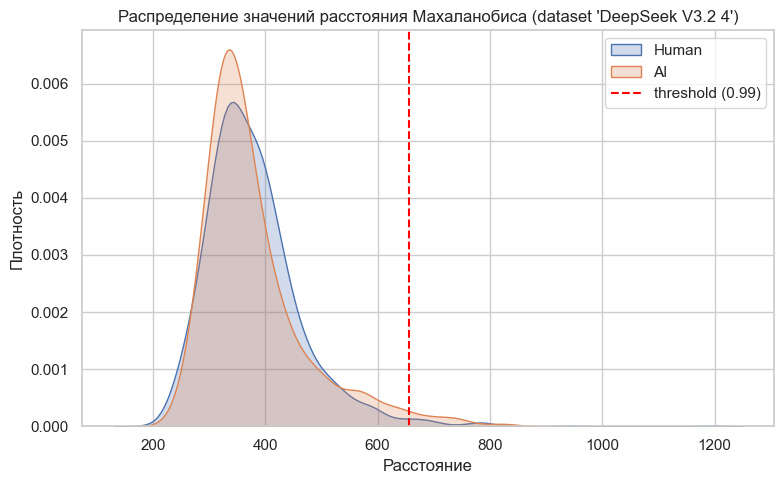

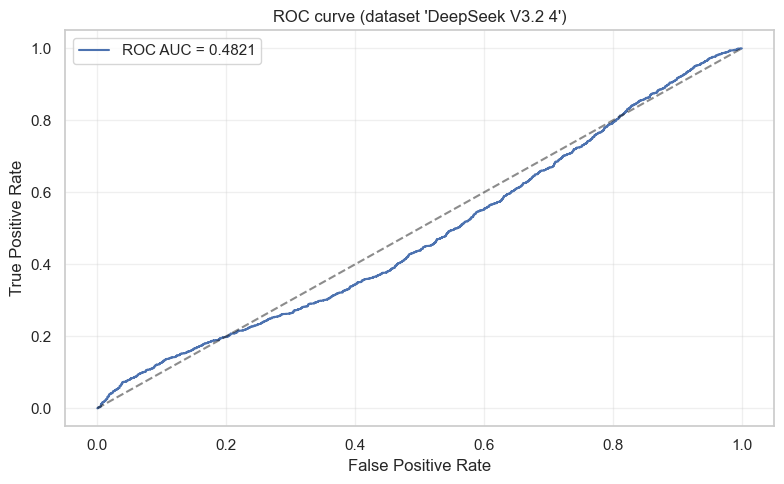

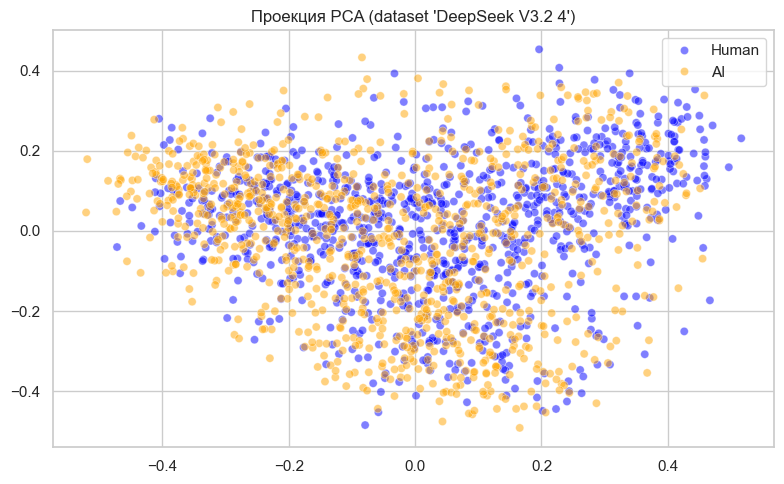


 DATASET 'DeepSeek V3.2 5' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.4848
F1:      0.0292


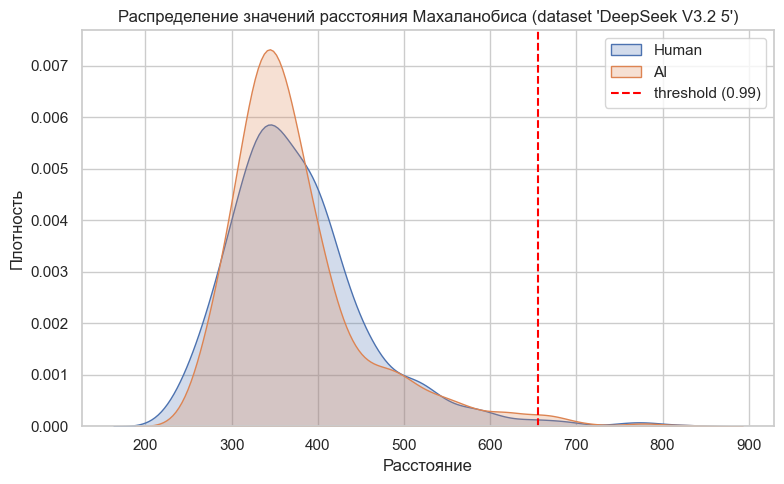

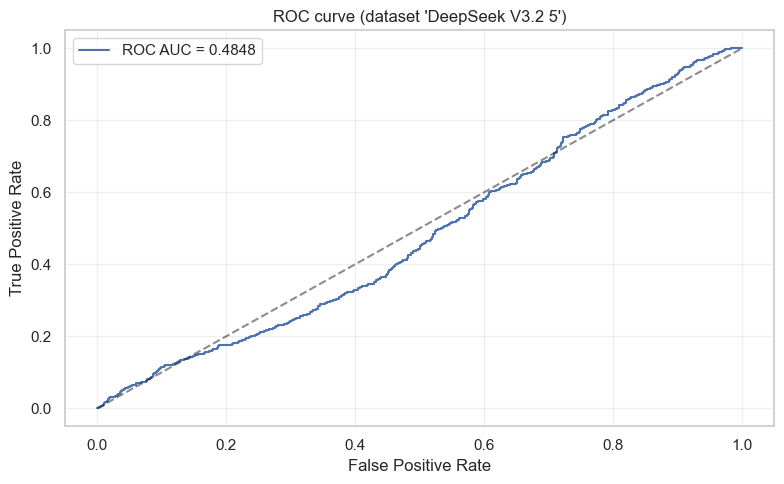

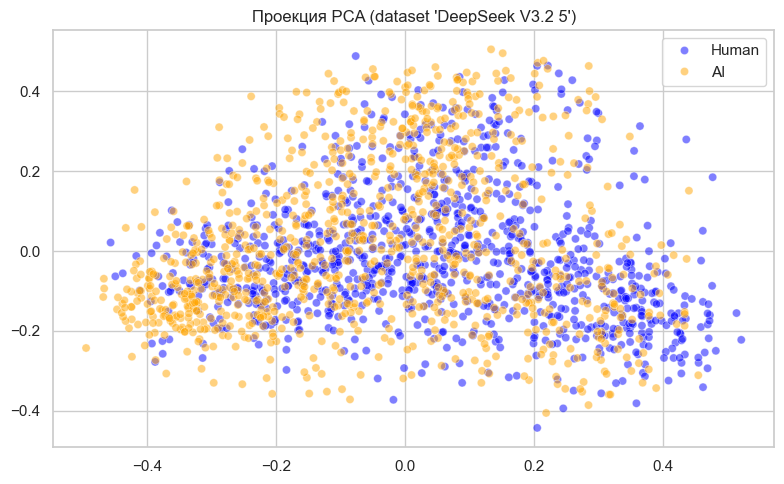


 DATASET 'ChatGPT 1' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5077
F1:      0.0426


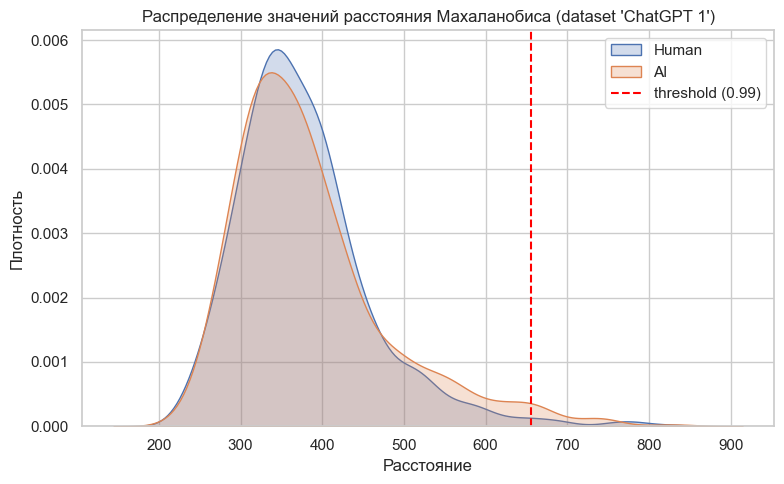

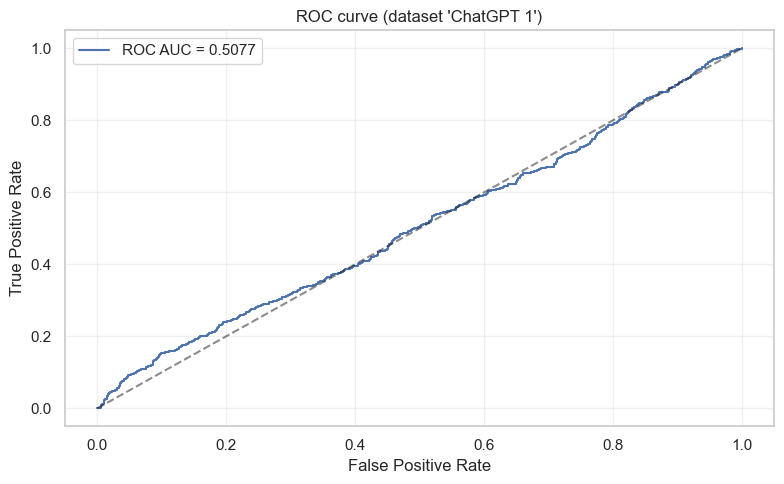

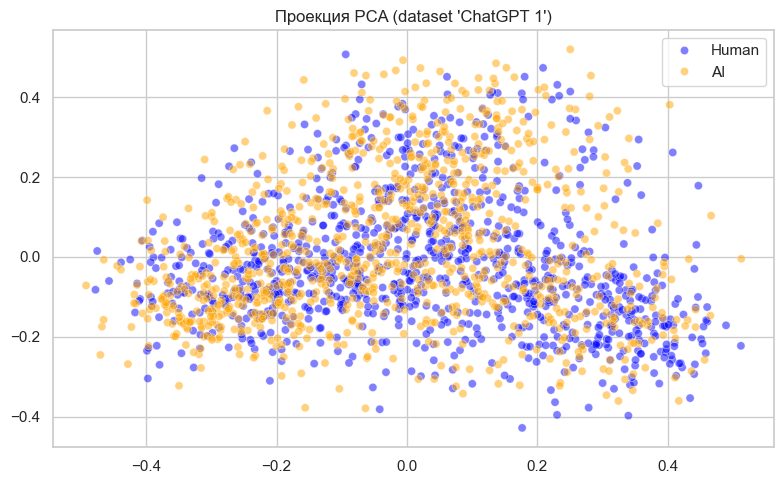


 DATASET 'ChatGPT 2' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5356
F1:      0.0369


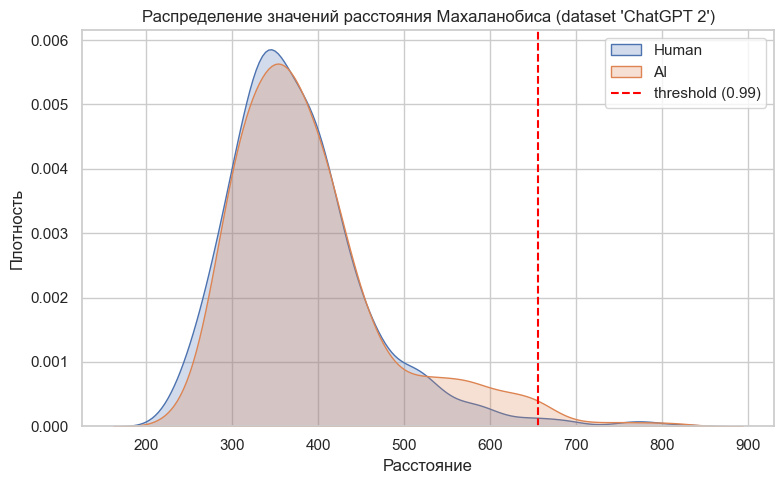

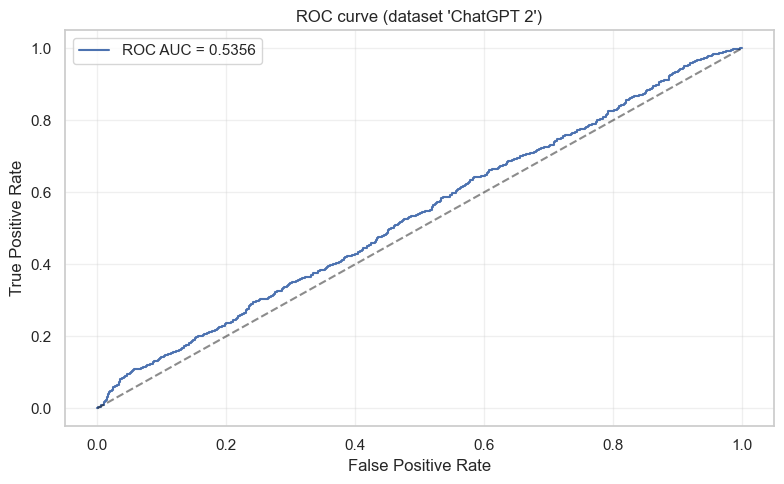

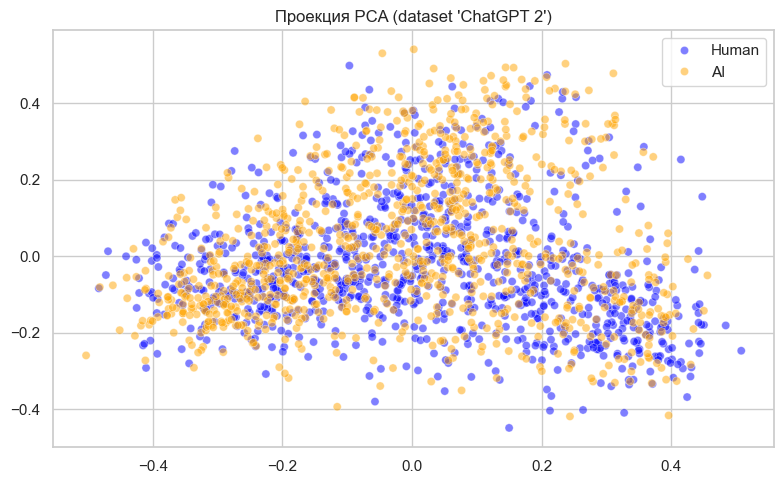


 DATASET 'ChatGPT 3' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5122
F1:      0.0292


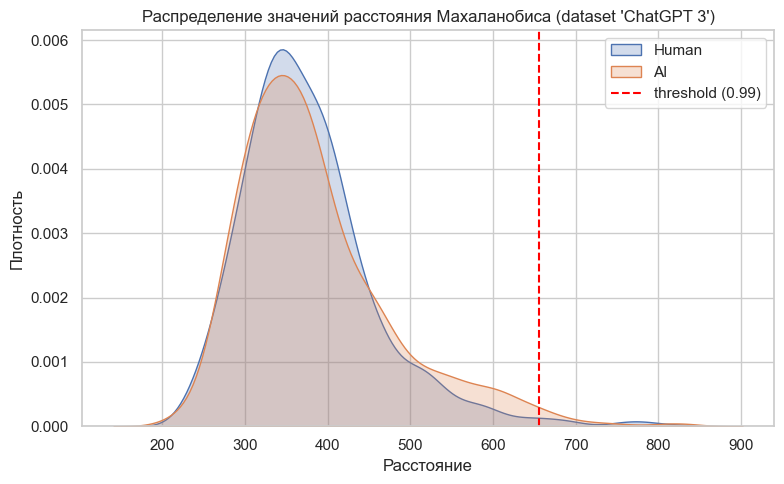

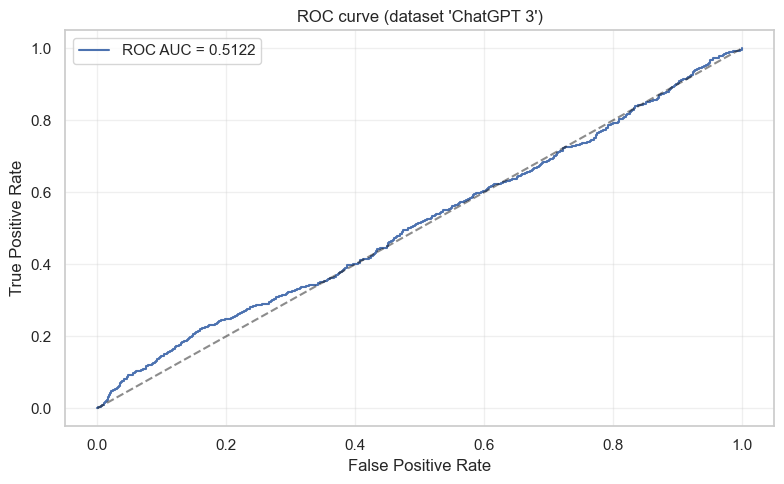

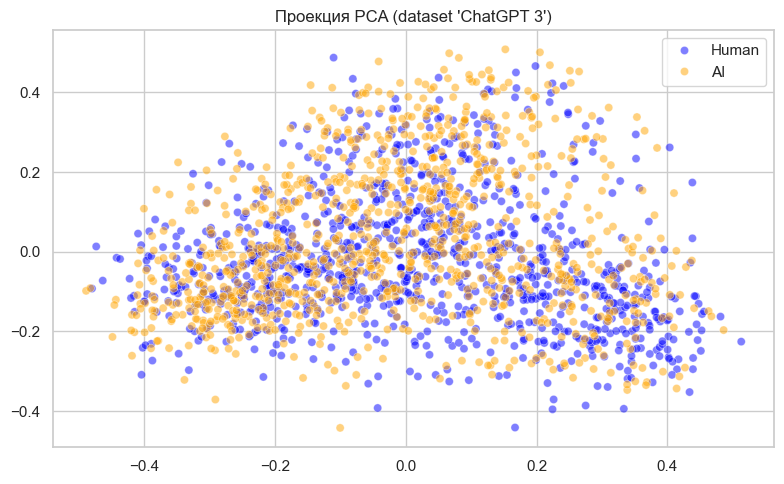


 DATASET 'ChatGPT 4' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5391
F1:      0.0444


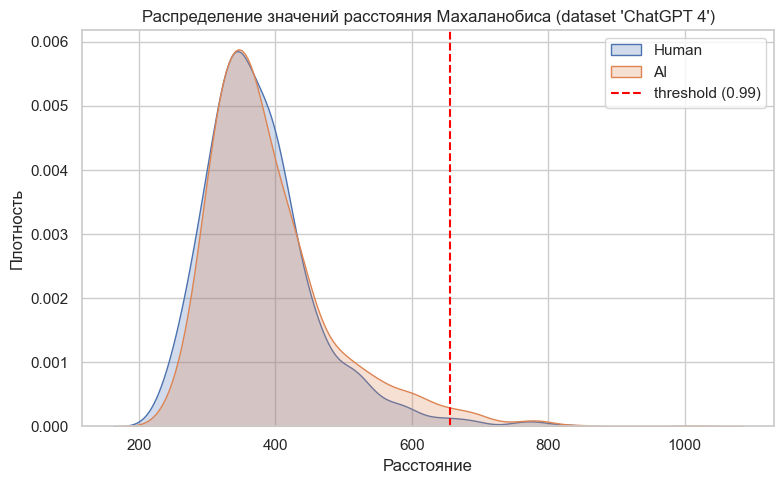

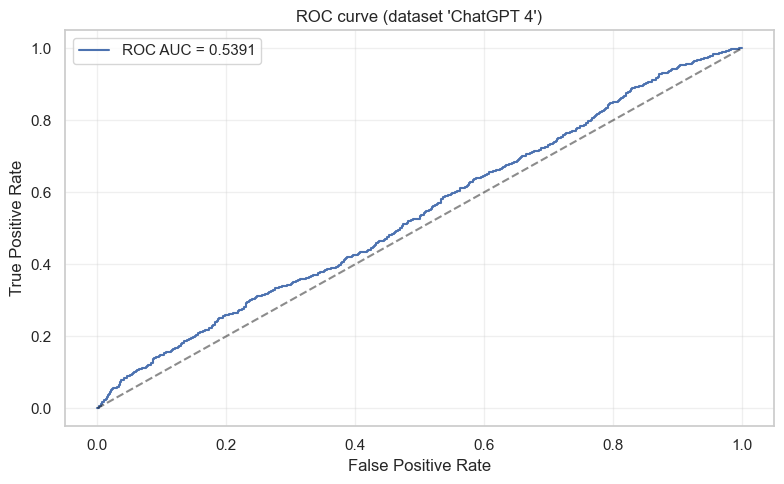

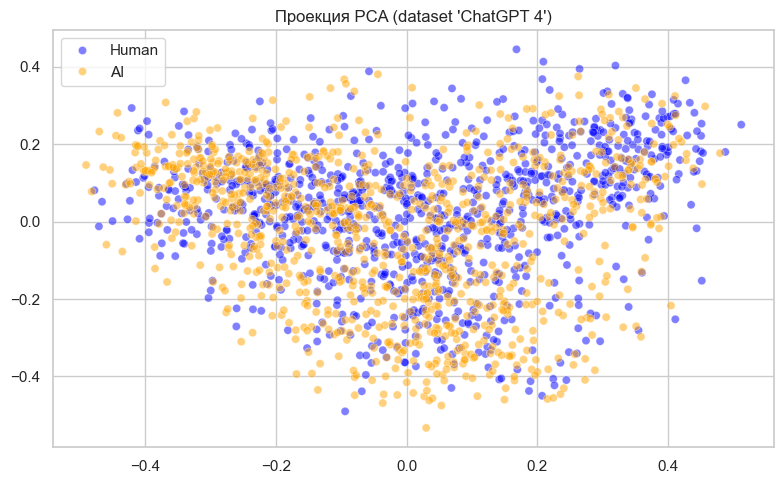


 DATASET 'ChatGPT 5' ====================================================


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

ROC-AUC: 0.5382
F1:      0.0369


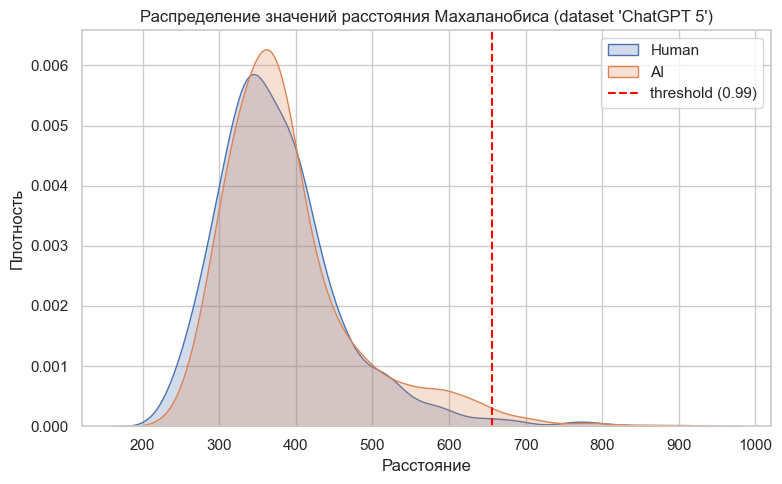

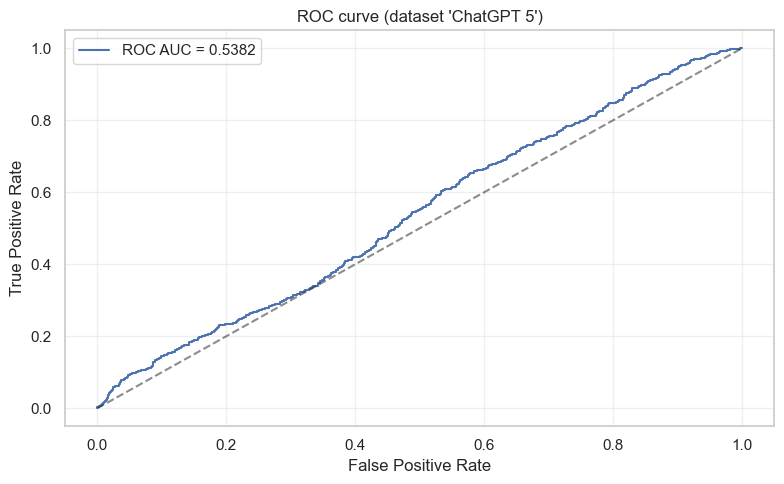

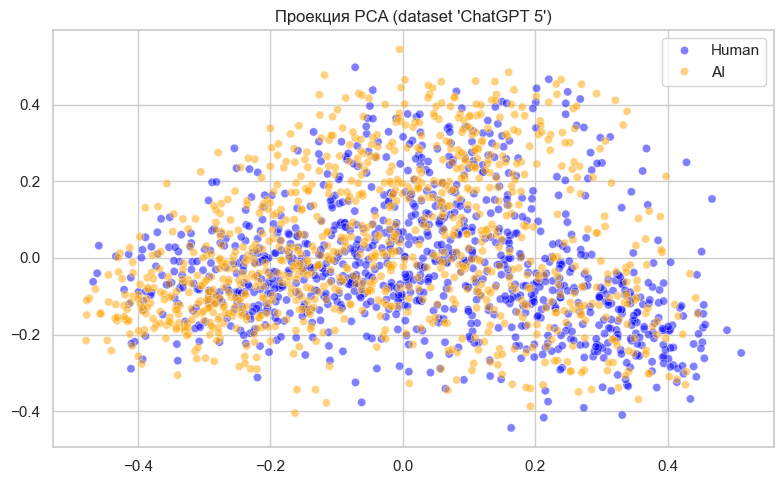

In [8]:
results = []
for name, ai_df in ai_datasets.items():
    print(f"\n DATASET '{name}' ====================================================")

    X_ai = encoder.encode(
        ai_df["text"].tolist(),
        batch_size=64,
        show_progress_bar=True
    )

    n = min(len(X_h_test), len(X_ai))
    
    X_test = np.vstack([
        X_h_test[:n],
        X_ai[:n]
    ])
    
    y_test = np.concatenate([
        np.zeros(n, dtype=int),
        np.ones(n, dtype=int)
    ])

    scores = cov.mahalanobis(X_test)
    scores_human = scores[:n]
    scores_ai = scores[n:]

    roc_auc = roc_auc_score(y_test, scores)

    # y_pred = (scores > chi2_threshold).astype(int)
    y_pred = (scores > emp_threshold).astype(int)
    f1 = f1_score(y_test, y_pred)

    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"F1:      {f1:.4f}")

    plot_mahalanobis_distributions(scores_human, scores_ai, emp_threshold, name)
    plot_roc_curve(y_test, scores, roc_auc, name)
    plot_pca_projection(X_h_test, X_ai, name)

    results.append({
        "dataset": name,
        "size": len(X_test),
        "roc_auc": roc_auc,
        "f1": f1
    })

In [9]:
results_df = pd.DataFrame(results)
print(results_df)

            dataset  size   roc_auc        f1
0      Mistral 7B 1  3000  0.583485  0.032383
1      Mistral 7B 2  3000  0.582677  0.037468
2      Mistral 7B 3  3000  0.577580  0.041264
3      Mistral 7B 4  3000  0.579293  0.034929
4      Mistral 7B 5  3000  0.579936  0.040000
5     Llama 3 13B 1  2000  0.583066  0.036857
6     Llama 3 13B 2  2000  0.583273  0.042553
7     Llama 3 13B 3  1996  0.576236  0.048309
8     Llama 3 13B 4  1996  0.569898  0.044530
9     Llama 3 13B 5  2000  0.551324  0.036857
10  DeepSeek V3.2 1  4000  0.465653  0.034918
11  DeepSeek V3.2 2  4000  0.490477  0.043457
12  DeepSeek V3.2 3  4000  0.470817  0.033964
13  DeepSeek V3.2 4  4000  0.482101  0.044402
14  DeepSeek V3.2 5  2000  0.484833  0.029211
15        ChatGPT 1  2000  0.507673  0.042553
16        ChatGPT 2  2000  0.535611  0.036857
17        ChatGPT 3  2000  0.512248  0.029211
18        ChatGPT 4  2000  0.539085  0.044444
19        ChatGPT 5  2000  0.538238  0.036857
